In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Creates the sqlalchemy engine and uses a SQL query to store the data in a dataframe
engine = create_engine('sqlite:///mta.db')
turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)

In [3]:
turnstiles_df['DATE'] = turnstiles_df['DATE'].astype('datetime64[ns]')
turnstiles_df['STATION_LINE'] = turnstiles_df.STATION + ", " + turnstiles_df.LINENAME
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392136 entries, 0 to 4392135
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   CA            object        
 1   UNIT          object        
 2   SCP           object        
 3   STATION       object        
 4   LINENAME      object        
 5   DIVISION      object        
 6   DATE          datetime64[ns]
 7   TIME          object        
 8   DESC          object        
 9   ENTRIES       int64         
 10  EXITS         int64         
 11  STATION_LINE  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 402.1+ MB


In [53]:
turnstiles_daily = (turnstiles_df
                        .groupby(["CA", "UNIT", "SCP", "STATION_LINE", "DATE"],as_index=False)
                        .ENTRIES.first())

turnstiles_hourly = turnstiles_df.copy()
turnstiles_hourly = turnstiles_hourly[turnstiles_hourly.TIME.isin(['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00','24:00:00'])]

turnstiles_hourly['HOURLY_AMT'] = turnstiles_hourly.groupby(["CA", "UNIT", "SCP", "STATION_LINE"]).ENTRIES.diff()
turnstiles_hourly[turnstiles_hourly.STATION_LINE =='34 ST-HERALD SQ, BDFMNQRW'].head(20)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE,HOURLY_AMT
1258322,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,04:00:00,REGULAR,28753647,12153782,"34 ST-HERALD SQ, BDFMNQRW",NaN
1258323,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,08:00:00,REGULAR,28753660,12153821,"34 ST-HERALD SQ, BDFMNQRW",13.0
1258324,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,12:00:00,REGULAR,28753722,12153908,"34 ST-HERALD SQ, BDFMNQRW",62.0
1258325,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,16:00:00,REGULAR,28753884,12154107,"34 ST-HERALD SQ, BDFMNQRW",162.0
1258326,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-14,20:00:00,REGULAR,28754076,12154287,"34 ST-HERALD SQ, BDFMNQRW",192.0
1258327,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,00:00:00,REGULAR,28754157,12154346,"34 ST-HERALD SQ, BDFMNQRW",81.0
1258328,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,04:00:00,REGULAR,28754162,12154349,"34 ST-HERALD SQ, BDFMNQRW",5.0
1258329,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,08:00:00,REGULAR,28754190,12154476,"34 ST-HERALD SQ, BDFMNQRW",28.0
1258330,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,12:00:00,REGULAR,28754323,12154810,"34 ST-HERALD SQ, BDFMNQRW",133.0
1258331,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,2021-03-15,16:00:00,REGULAR,28754591,12154995,"34 ST-HERALD SQ, BDFMNQRW",268.0


In [54]:
turnstiles_daily['DAILY_TOT'] = turnstiles_daily.groupby(["CA", "UNIT", "SCP", "STATION_LINE"]).ENTRIES.diff()
turnstiles_daily['DAILY_TOT_ABS'] = np.absolute(turnstiles_daily.DAILY_TOT)

turnstiles_hourly['HOURLY_AMT_ABS'] = np.absolute(turnstiles_hourly.HOURLY_AMT)

In [56]:
mask = (turnstiles_daily.DAILY_TOT_ABS < 15000)
maskh = (turnstiles_hourly.HOURLY_AMT_ABS < 2000)
turnstiles_daily_cleaned = turnstiles_daily[mask]
turnstiles_hourly_cleaned = turnstiles_hourly[maskh]
mask_shift = (turnstiles_daily.SCP.shift(1) != turnstiles_daily.SCP)
#turnstiles_daily['DAILY_TOT'][mask_shift] = np.nan
#turnstiles_daily.loc[mask_shift,'DAILY_TOT'] = np.nan
#turnstiles_daily[(turnstiles_daily.STATION == 'HEWES ST') & (turnstiles_daily.SCP == '00-00-00')]


In [57]:
station_daily = turnstiles_daily_cleaned.groupby(['STATION_LINE','DATE'])[['DAILY_TOT_ABS']].sum().reset_index()
station_daily_sum = station_daily.groupby('STATION_LINE').DAILY_TOT_ABS.sum().reset_index().sort_values('DAILY_TOT_ABS',ascending = False).head(15)
station_daily_sum['STATION'] = station_daily_sum.STATION_LINE.apply(lambda x: x[:x.find(',')])

station_hourly = turnstiles_hourly_cleaned.groupby(['STATION_LINE','TIME'])[['HOURLY_AMT_ABS']].mean().reset_index()

top_list = station_daily_sum.STATION_LINE.head(5).to_list()

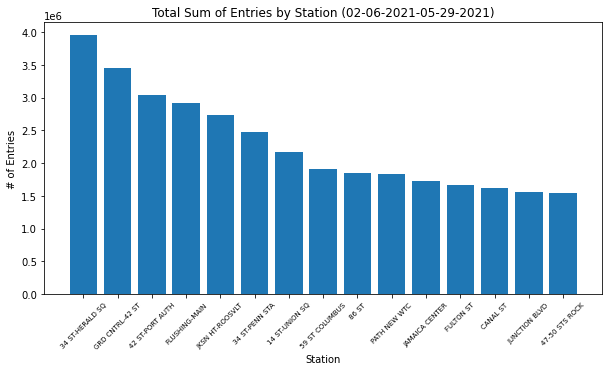

In [58]:
plt.figure(figsize=(10,5))

plt.bar(station_daily_sum.STATION_LINE, station_daily_sum.DAILY_TOT_ABS, tick_label = station_daily_sum.STATION)
plt.ylabel('# of Entries')
plt.xlabel('Station')
plt.xticks(rotation=45, size = 7)
plt.title('Total Sum of Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('figs/tot_sum_by_stat.png', bbox_inches = 'tight')

In [59]:
daily_by_station = (turnstiles_daily_cleaned
                    .groupby(['STATION_LINE','DATE'])
                    .DAILY_TOT_ABS.sum().reset_index())

station_hourly_top = station_hourly[station_hourly.STATION_LINE.isin(top_list)].reset_index()

top_list = station_daily_sum.STATION_LINE.head(5).to_list()
top_station_mask = daily_by_station['STATION_LINE'].isin(top_list)

daily_by_station_top = daily_by_station[top_station_mask].reset_index()

station_daily_sum.sort_values(['DAILY_TOT_ABS'], ascending = False)

station_hourly_top.sort_values(by = ['HOURLY_AMT_ABS'], ascending = False).head(20)

,index,STATION_LINE,TIME,HOURLY_AMT_ABS
27,1959,"JKSN HT-ROOSVLT, EFMR7",12:00:00,246.857892
15,1671,"FLUSHING-MAIN, 7",12:00:00,230.553766
5,515,"34 ST-HERALD SQ, BDFMNQRW",20:00:00,213.396899
17,1673,"FLUSHING-MAIN, 7",20:00:00,203.120322
28,1960,"JKSN HT-ROOSVLT, EFMR7",16:00:00,202.707040
16,1672,"FLUSHING-MAIN, 7",16:00:00,180.873994
14,1670,"FLUSHING-MAIN, 7",08:00:00,179.113306
29,1961,"JKSN HT-ROOSVLT, EFMR7",20:00:00,178.869221
26,1958,"JKSN HT-ROOSVLT, EFMR7",08:00:00,175.992046
8,578,"42 ST-PORT AUTH, ACENQRS1237W",08:00:00,148.620181


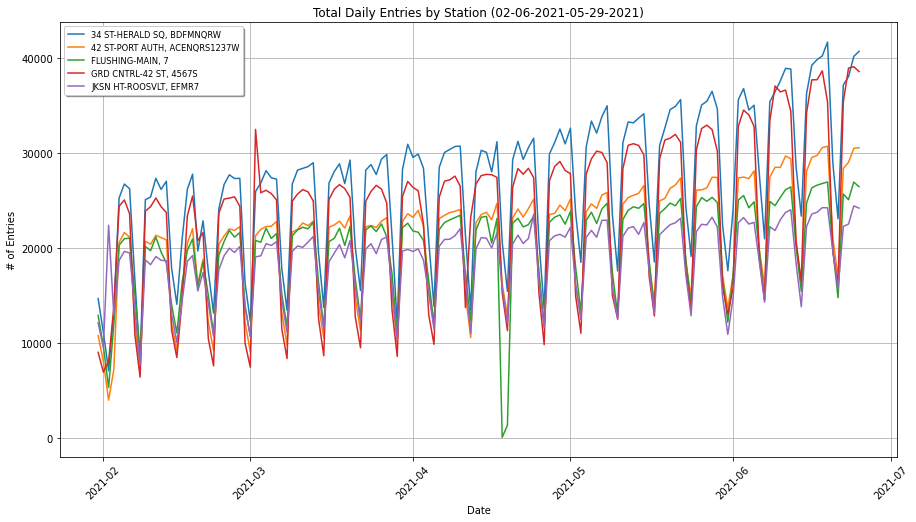

In [60]:
plt.figure(figsize=(15,8))
plt.grid() 
for i, group in daily_by_station_top.groupby('STATION_LINE'):
    plt.plot(group['DATE'], group['DAILY_TOT_ABS'], label = i)

plt.legend(shadow = True, loc = 0, fontsize = 'small')
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Total Daily Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('figs/daily_entries_by_station.png', bbox_inches = 'tight')

In [61]:
daily_by_station_top['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_by_station_top['DATE']).dt.dayofweek
daily_by_station_top

,index,STATION_LINE,DATE,DAILY_TOT_ABS,DAY_OF_WEEK_NUM
0,12992,"34 ST-HERALD SQ, BDFMNQRW",2021-01-31,14660.0,6
1,12993,"34 ST-HERALD SQ, BDFMNQRW",2021-02-01,11100.0,0
2,12994,"34 ST-HERALD SQ, BDFMNQRW",2021-02-02,7047.0,1
3,12995,"34 ST-HERALD SQ, BDFMNQRW",2021-02-03,13406.0,2
4,12996,"34 ST-HERALD SQ, BDFMNQRW",2021-02-04,25261.0,3
...,...,...,...,...,...
725,49626,"JKSN HT-ROOSVLT, EFMR7",2021-06-21,15656.0,0
726,49627,"JKSN HT-ROOSVLT, EFMR7",2021-06-22,22254.0,1
727,49628,"JKSN HT-ROOSVLT, EFMR7",2021-06-23,22514.0,2
728,49629,"JKSN HT-ROOSVLT, EFMR7",2021-06-24,24428.0,3


In [67]:
daily_by_station_dow_mean = daily_by_station_top.groupby(['STATION_LINE','DAY_OF_WEEK_NUM']).DAILY_TOT_ABS.mean().reset_index()
daily_by_station_sum.head()

,STATION_LINE,DAY_OF_WEEK_NUM,DAILY_TOT_ABS
0,"34 ST-HERALD SQ, BDFMNQRW",0,15627.666667
1,"34 ST-HERALD SQ, BDFMNQRW",1,27957.619048
2,"34 ST-HERALD SQ, BDFMNQRW",2,30521.190476
3,"34 ST-HERALD SQ, BDFMNQRW",3,31564.809524
4,"34 ST-HERALD SQ, BDFMNQRW",4,31216.142857


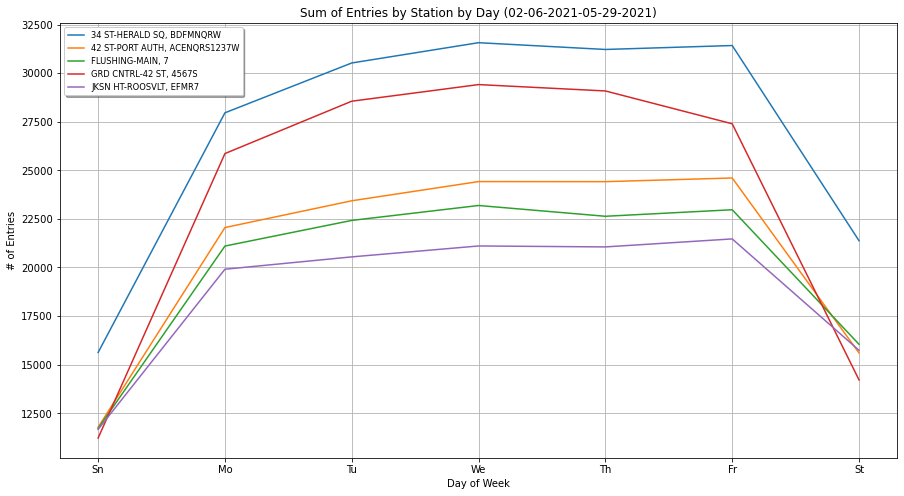

In [63]:
plt.figure(figsize=(15,8))
plt.grid() 
for i, group in daily_by_station_dow_mean.groupby('STATION_LINE'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_TOT_ABS'], label = i)
    
plt.legend(shadow = True, loc = 0, fontsize = 'small')

plt.ylabel('# of Entries')
plt.xlabel('Day of Week')
plt.xticks(np.arange(7),['Sn','Mo','Tu','We','Th','Fr','St'])
plt.title('Sum of Entries by Station by Day (02-06-2021-05-29-2021)')

plt.savefig('figs/daily_entries_sum_week.png', bbox_inches = 'tight')

<ipython-input-64-c096f008ed26>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','Sn','Mo','Tu','We','Th','Fr','St'])


<Figure size 1080x1080 with 0 Axes>

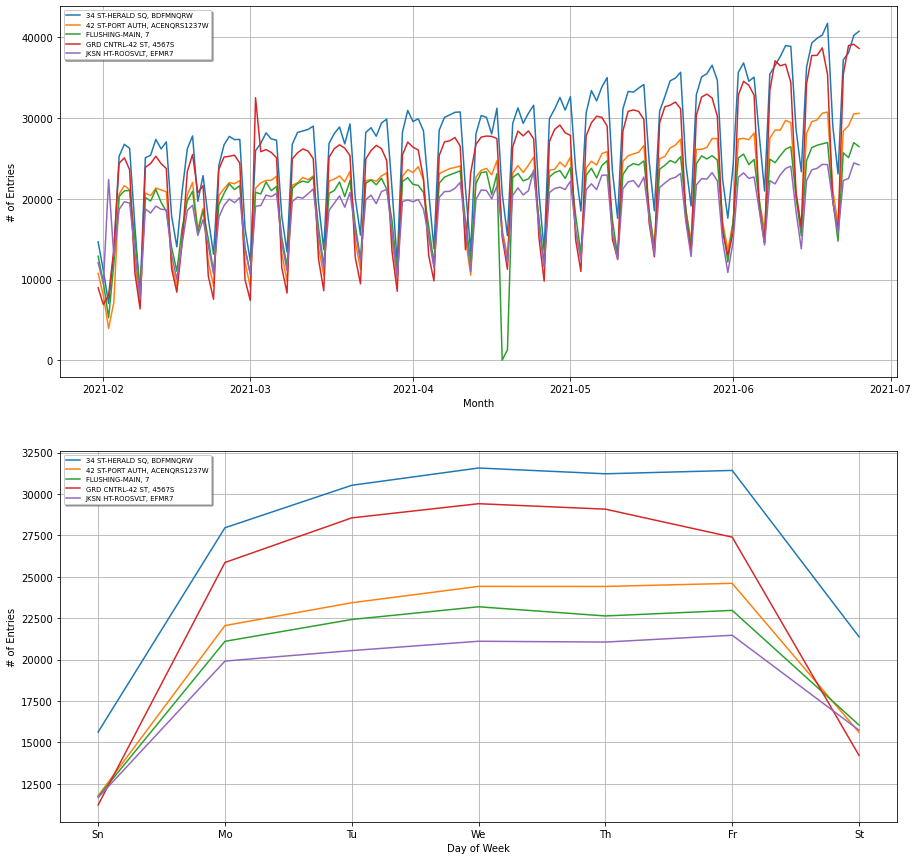

In [64]:
plt.figure(figsize=(15,15))
fig, (ax1,ax2) = plt.subplots(2, figsize = (15,15))
ax2.grid() 
for i, group in daily_by_station_dow_mean.groupby('STATION_LINE'):
    ax2.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_TOT_ABS'], label = i)
    
ax2.legend(shadow = True, loc = 0, fontsize = 'x-small')
ax2.set(xlabel = 'Day of Week', ylabel = '# of Entries')
ax2.set_xticklabels(['','Sn','Mo','Tu','We','Th','Fr','St'])
# ax1.ylabel('# of Entries')
# ax1.xlabel('Day of Week')
# 
# ax1.title('Sum of Entries by Station by Day (02-06-2021-05-29-2021)')
ax1.grid()
for i, group in daily_by_station_top.groupby('STATION_LINE'):
    ax1.plot(group['DATE'], group['DAILY_TOT_ABS'], label = i)

ax1.legend(shadow = True, loc = 0, fontsize = 'x-small')
ax1.set(xlabel = 'Month', ylabel = '# of Entries')
# ax2.ylabel('# of Entries')
# ax2.xlabel('Date')
# ax2.xticks(rotation=45)
# ax2.title('Total Daily Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('figs/fig_subplot.png', bbox_inches = 'tight')

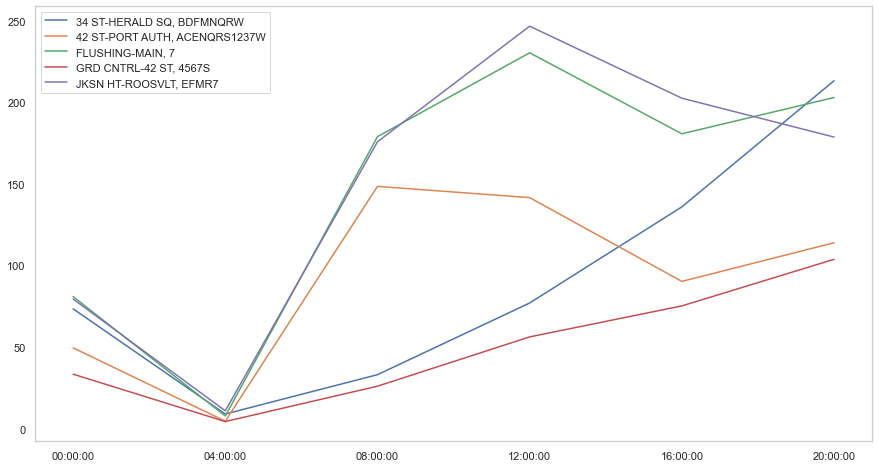

In [81]:
plt.figure(figsize=(15,8))
plt.grid()
for i, group in station_hourly_top.groupby('STATION_LINE'):
    plt.plot(group['TIME'],group['HOURLY_AMT_ABS'], label = i)
plt.legend()

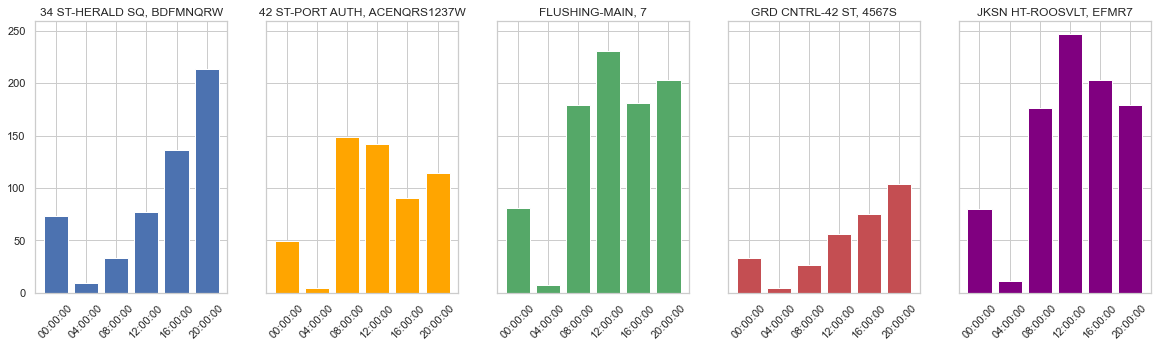

In [117]:
color_lst = ['b','orange','g','r','purple']
y_ticks = [0,50,100,150,200,250]
fig, axs = plt.subplots(1,5, figsize=(20,5), sharey = 'row')
idx = 0
for i, group in station_hourly_top.groupby('STATION_LINE'):
    axs[idx].bar(group['TIME'],group['HOURLY_AMT_ABS'], label = i, color = color_lst[idx])
    axs[idx].set_title(i)
    axs[idx].tick_params('x',labelrotation = 45)
    idx+=1